## Imports

In [269]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [270]:
ratings = pd.read_csv('ratings.csv')
movies = pd.read_csv('movies.csv')

## Exploratory Data

In [271]:
n_ratings = len(ratings)
n_movies = ratings['movieId'].nunique() #gets unique movies
n_users = ratings['userId'].nunique()

print(f'Number of ratings {n_ratings}')
print(f'Number of movies {n_movies}')
print(f'Number of users = {n_users}')
print(f'Avg number of ratings per user: {round(n_ratings/n_users,2)}')
print(f'Avg number of ratings per movie: {round(n_ratings/n_movies,2)}')

Number of ratings 100836
Number of movies 9724
Number of users = 610
Avg number of ratings per user: 165.3
Avg number of ratings per movie: 10.37


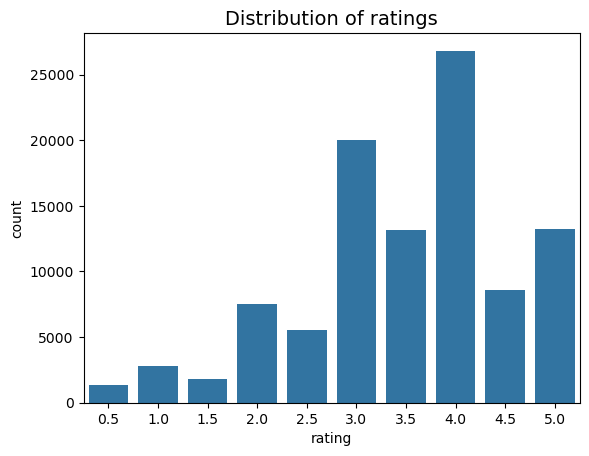

In [272]:
sns.countplot(x='rating', data = ratings)
plt.title("Distribution of ratings", fontsize=14)
plt.show()

In [273]:
print(f'Mean global rating: {round(ratings['rating'].mean(),2)}')

Mean global rating: 3.5


In [274]:
mean_ratings = ratings.groupby('userId')['rating'].mean()
print(f'Mean ratings per user: {round(mean_ratings.mean(),2)}')

Mean ratings per user: 3.66


In [275]:
ratings['movieId'].value_counts()

movieId
356       329
318       317
296       307
593       279
2571      278
         ... 
86279       1
86922       1
5962        1
87660       1
163981      1
Name: count, Length: 9724, dtype: int64

### 10 most rated movies

In [276]:
movie_ratings = ratings.merge(movies, on="movieId") #merges the two dataframes based on column column of userId
movie_ratings['title'].value_counts()[0:10] #counts unique occurrences in title column, sorts in descending order

title
Forrest Gump (1994)                          329
Shawshank Redemption, The (1994)             317
Pulp Fiction (1994)                          307
Silence of the Lambs, The (1991)             279
Matrix, The (1999)                           278
Star Wars: Episode IV - A New Hope (1977)    251
Jurassic Park (1993)                         238
Braveheart (1995)                            237
Terminator 2: Judgment Day (1991)            224
Schindler's List (1993)                      220
Name: count, dtype: int64

### Lowest and highest rated movies

In [277]:
mean_ratings = ratings.groupby('movieId')[['rating']].mean()

lowest_rating = mean_ratings['rating'].idxmin()
movies[movies['movieId']==lowest_rating]


,movieId,title,genres
2689,3604,Gypsy (1962),Musical


In [278]:
highest_rating = mean_ratings['rating'].idxmax()
movies[movies['movieId']==highest_rating]
#ratings[ratings['movieId']==highest_rating]
# Note: this method isn't the most accurate, since it evaluates each movie solely off of ratings (not # of ratings)
# A better approach is the Bayesian average

,movieId,title,genres
48,53,Lamerica (1994),Adventure|Drama


## Bayesian Average Calculation

In [279]:
movie_stats = ratings.groupby('movieId')['rating'].agg(['count','mean'])
#groups the data by movieId then applies the count function, which gets the # of ratings each movie has, and mean, which is the average rating
# create a new data frame with count and mean
movie_stats.head()

,count,mean
movieId,,
1,215,3.920930
2,110,3.431818
3,52,3.259615
4,7,2.357143
5,49,3.071429


In [280]:
C = movie_stats['count'].mean()
m = movie_stats['mean'].mean()

print(f'Avg # of ratings for a given movie: {C:.2f}')
print(f'Avg rating per movie {m:.2f}')

def bayesian_avg(ratings):
    bayesian_avg = (C*m+ratings.sum())/(C+ratings.count())
    return round(bayesian_avg,3)

Avg # of ratings for a given movie: 10.37
Avg rating per movie 3.26


### test bayesian avg on a specific movie

In [281]:
lamerica = pd.Series([5,5]) #this was the highest-rated movie, however only with 2 reviews
bayesian_avg(lamerica)

3.543

### applying to all movies

In [282]:
bayesian_avg_ratings = ratings.groupby('movieId')['rating'].agg(bayesian_avg).reset_index()
'''
groups by movieId, selecting the column rating
.agg applies the bayesian_avg function to rating series for each group
after aggregation, the result is a series where movieId is used as an index: reset_index turns this series back into a dataframe
'''
bayesian_avg_ratings.columns = ['movieId','bayesian_avg']
movie_stats = movie_stats.merge(bayesian_avg_ratings, on='movieId')

movie_stats.head()

,movieId,count,mean,bayesian_avg
0,1,215,3.920930,3.891
1,2,110,3.431818,3.417
2,3,52,3.259615,3.260
3,4,7,2.357143,2.898
4,5,49,3.071429,3.105


In [283]:
movie_stats = movie_stats.merge(movies[['movieId','title']])
movie_stats.sort_values(by='bayesian_avg', ascending=True).head() # highest or lowest rated movies based on bayesian

,movieId,count,mean,bayesian_avg,title
1172,1556,19,1.605263,2.190,Speed 2: Cruise Control (1997)
2679,3593,19,1.657895,2.224,Battlefield Earth (2000)
1372,1882,33,1.954545,2.267,Godzilla (1998)
1144,1499,27,1.925926,2.297,Anaconda (1997)
1988,2643,16,1.687500,2.307,Superman IV: The Quest for Peace (1987)


## Movie Genres

In [284]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


## cleaning up genre by converting to list

In [285]:
movies['genres'] = movies['genres'].apply(lambda x:x.split('|'))
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]


In [286]:
from collections import Counter
genre_freq = Counter(g for genres in movies['genres'] for g in genres)
print(f'There are {len(genre_freq)} genres')

genre_freq

There are 20 genres


Counter({'Drama': 4361,
         'Comedy': 3756,
         'Thriller': 1894,
         'Action': 1828,
         'Romance': 1596,
         'Adventure': 1263,
         'Crime': 1199,
         'Sci-Fi': 980,
         'Horror': 978,
         'Fantasy': 779,
         'Children': 664,
         'Animation': 611,
         'Mystery': 573,
         'Documentary': 440,
         'War': 382,
         'Musical': 334,
         'Western': 167,
         'IMAX': 158,
         'Film-Noir': 87,
         '(no genres listed)': 34})

In [287]:
print(f'Most popular genres: {genre_freq.most_common(5)}')

Most popular genres: [('Drama', 4361), ('Comedy', 3756), ('Thriller', 1894), ('Action', 1828), ('Romance', 1596)]


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [Text(0, 0, 'Drama'),
  Text(1, 0, 'Comedy'),
  Text(2, 0, 'Thriller'),
  Text(3, 0, 'Action'),
  Text(4, 0, 'Romance'),
  Text(5, 0, 'Adventure'),
  Text(6, 0, 'Crime'),
  Text(7, 0, 'Sci-Fi'),
  Text(8, 0, 'Horror'),
  Text(9, 0, 'Fantasy'),
  Text(10, 0, 'Children'),
  Text(11, 0, 'Animation'),
  Text(12, 0, 'Mystery'),
  Text(13, 0, 'Documentary'),
  Text(14, 0, 'War'),
  Text(15, 0, 'Musical'),
  Text(16, 0, 'Western'),
  Text(17, 0, 'IMAX'),
  Text(18, 0, 'Film-Noir'),
  Text(19, 0, '(no genres listed)')])

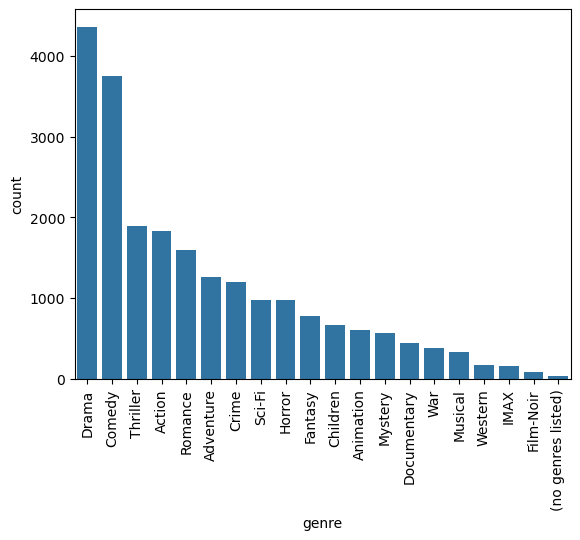

In [288]:
genre_freq_df = pd.DataFrame([genre_freq]).T.reset_index()
genre_freq_df.columns = ['genre','count']

sns.barplot(x='genre', y='count', data=genre_freq_df.sort_values(by='count', ascending=False))
plt.xticks(rotation=90)

## Data preprocessing

In [289]:
'''
create_X function outputs a sparse matrix X with 4 mapper dictionaries:
1. user_mapper: maps userid to user index
2. movie_mapper: maps movie id to movie index
3. user_inv_mapper: maps user index to user id
4. movie_inv_mapper: maps movie index to movie id
these dictionaries map which row/column of the matrix corresponds to which user/movie id
'''

from scipy.sparse import csr_matrix

def create_X(df):
    M = df['userId'].nunique()
    N = df['movieId'].nunique()

    user_mapper = dict(zip(np.unique(df['userId']),list(range(M))))
    movie_mapper = dict(zip(np.unique(df['movieId']),list(range(N))))

    user_inv_mapper = dict(zip(list(range(M)),np.unique(df['userId'])))
    movie_inv_mapper = dict(zip(list(range(N)),np.unique(df['movieId'])))

    user_index = [user_mapper[i] for i in df['userId']]
    item_index = [movie_mapper[i] for i in df['movieId']]

    X = csr_matrix((df["rating"], (user_index, item_index)), shape=(M,N))
    return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper

X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_X(ratings)

# csr matrix - sparse matrix in scipy

In [290]:
X.shape
#there are empty cells, but it is space efficient

(610, 9724)

In [291]:
user_mapper

{1: 0,
 2: 1,
 3: 2,
 4: 3,
 5: 4,
 6: 5,
 7: 6,
 8: 7,
 9: 8,
 10: 9,
 11: 10,
 12: 11,
 13: 12,
 14: 13,
 15: 14,
 16: 15,
 17: 16,
 18: 17,
 19: 18,
 20: 19,
 21: 20,
 22: 21,
 23: 22,
 24: 23,
 25: 24,
 26: 25,
 27: 26,
 28: 27,
 29: 28,
 30: 29,
 31: 30,
 32: 31,
 33: 32,
 34: 33,
 35: 34,
 36: 35,
 37: 36,
 38: 37,
 39: 38,
 40: 39,
 41: 40,
 42: 41,
 43: 42,
 44: 43,
 45: 44,
 46: 45,
 47: 46,
 48: 47,
 49: 48,
 50: 49,
 51: 50,
 52: 51,
 53: 52,
 54: 53,
 55: 54,
 56: 55,
 57: 56,
 58: 57,
 59: 58,
 60: 59,
 61: 60,
 62: 61,
 63: 62,
 64: 63,
 65: 64,
 66: 65,
 67: 66,
 68: 67,
 69: 68,
 70: 69,
 71: 70,
 72: 71,
 73: 72,
 74: 73,
 75: 74,
 76: 75,
 77: 76,
 78: 77,
 79: 78,
 80: 79,
 81: 80,
 82: 81,
 83: 82,
 84: 83,
 85: 84,
 86: 85,
 87: 86,
 88: 87,
 89: 88,
 90: 89,
 91: 90,
 92: 91,
 93: 92,
 94: 93,
 95: 94,
 96: 95,
 97: 96,
 98: 97,
 99: 98,
 100: 99,
 101: 100,
 102: 101,
 103: 102,
 104: 103,
 105: 104,
 106: 105,
 107: 106,
 108: 107,
 109: 108,
 110: 109,
 111: 11

## Evaluating sparsity

Determine whether collaborative filtering is suitable. Too sparse = content base filtering is likely better.

In [292]:
n_total = X.shape[0] * X.shape[1]
n_ratings = X.nnz #count of how many non empty elements in matrix. counts stored values 

sparsity = n_ratings/n_total
print(f'Matrix sparsity: {round(sparsity*100,2)}%')
# On average: a sparsity of .1% is good to go for collaborative filtering. otherwise, use content based filtering

Matrix sparsity: 1.7%


## Evaluating Cold Start

Cold start problems: new users in the matrices that do not have any ratings.  ** This will be vital later on for my project later :) 
In this dataset, there are no empty terms as we can see below.

In [293]:
n_ratings_per_user = X.getnnz(axis=1) # number of non zero terms in sparse matrix
len(n_ratings_per_user) # expected: 610 determined by shape above

most_active_user = n_ratings_per_user.max()
print(f'The most active user rated {most_active_user} movies.')

least_active_user = n_ratings_per_user.min()
print(f'The least active user rated {least_active_user} movies.')

The most active user rated 2698 movies.
The least active user rated 20 movies.


In [294]:
n_ratings_per_movie = X.getnnz(axis=0)
len(n_ratings_per_movie)

most_active_movie = n_ratings_per_movie.max()
print(f'The most actively rated movie is {most_active_movie}.')

least_active_movie = n_ratings_per_movie.min()
print(f'The least actively rated movied is {least_active_movie}.')

The most actively rated movie is 329.
The least actively rated movied is 1.


## Plotting the sparsity

Text(0, 0.5, 'density')

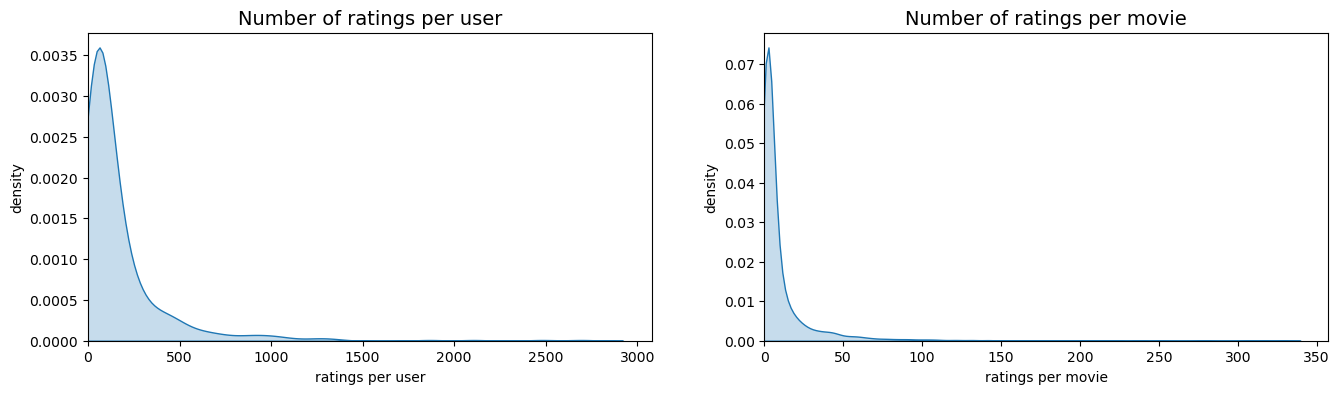

In [295]:
plt.figure(figsize=(16,4))
#by default, matplotlib will fit your data to hold the plot, however fitting it manually will give you control over your data set

#subplot 1 
plt.subplot(1,2,1) #subplot(n_rows,n_columns, index)
sns.kdeplot(n_ratings_per_user, fill=True)
plt.xlim(0)
plt.title("Number of ratings per user", fontsize=14)
plt.xlabel("ratings per user")
plt.ylabel("density")

#subplot 2
plt.subplot(1,2,2)
sns.kdeplot(n_ratings_per_movie, fill=True)
plt.xlim(0)
plt.title("Number of ratings per movie", fontsize=14)
plt.xlabel("ratings per movie")
plt.ylabel("density")

## K-nearest neighbours

Now that we have ensured that our dataset is sparse enough to do collaborative filtering, we will build our k-nearest neighbours model.
So, we will find the k movies that have the most similar user engagement vectors for movie i.

In [296]:
from sklearn.neighbors import NearestNeighbors

def find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper,k, metric="cosine"):
    '''
    K-nearest algorithm: k-nearest neighbours given a movie id.

    Args:
        movie_id: id of movie of interest
        X: user-item utility matrix
        k: number of similar movies to retrieve
        metric: distance for kNN calculations, focusing on cosine similarity

    Outputs:
        list of k similar movie-ids
    '''
    X = X.T
    neighbour_ids=[]
    movie_ind = movie_mapper[movie_id]
    movie_vec = X[movie_ind]

    if isinstance(movie_vec, (np.ndarray)):
        movie_vec = movie_vec.reshape(1, -1) 
    # use k+t as kNN output includes movieId of interest
    kNN = NearestNeighbors(n_neighbors=k+1, algorithm="brute", metric=metric)
    kNN.fit(X)
    neighbour = kNN.kneighbors(movie_vec, return_distance=False)
    for i in range(0,k):
        n = neighbour.item(i)
        neighbour_ids.append(movie_inv_mapper[n])
    neighbour_ids.pop(0)
    return neighbour_ids

In [297]:
# similar_movies = find_similar_movies(1,X,movie_mapper,movie_inv_mapper,k=10)
# similar_movies

In [298]:
movie_titles = dict(zip(movies['movieId'],movies['title']))
movie_id = 1
similar_movies = find_similar_movies(movie_id,X,movie_mapper,movie_inv_mapper,metric='cosine',k=10)
movie_title = movie_titles[movie_id]
print(f'Since you watched {movie_title}, we recommend:')
for n in similar_movies:
    print(movie_titles[n])
    


Since you watched Toy Story (1995), we recommend:
Toy Story 2 (1999)
Jurassic Park (1993)
Independence Day (a.k.a. ID4) (1996)
Star Wars: Episode IV - A New Hope (1977)
Forrest Gump (1994)
Lion King, The (1994)
Star Wars: Episode VI - Return of the Jedi (1983)
Mission: Impossible (1996)
Groundhog Day (1993)


## Cold start problem

Using content-based filtering using genres. 

In [299]:
n_movies = movies['movieId'].nunique()
print(f'There are {n_movies} unique movies in our dataset.')

There are 9742 unique movies in our dataset.


In [300]:
genres = set(g for G in movies['genres'] for g in G) #creates a set of unique genres in the genre column

for g in genres:
    movies[g] = movies.genres.transform(lambda x:int(g in x))
    #transform method is applied to genres column, checks if genre g is present in each entry x in the movies genre column
movie_genres = movies.drop(columns=['movieId','title','genres'])
movie_genres

,Drama,Film-Noir,Western,Children,Adventure,Action,(no genres listed),Animation,Mystery,Fantasy,Documentary,Thriller,Sci-Fi,Musical,Comedy,Crime,Horror,IMAX,War,Romance
0,0,0,0,1,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0
1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9737,0,0,0,0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0
9738,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0
9739,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9740,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [301]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(movie_genres, movie_genres)
print(f'Dimensions of our genres cosine similarity matrix: {cosine_sim.shape}')

Dimensions of our genres cosine similarity matrix: (9742, 9742)


In [302]:
cosine_sim[0] #1 means very similar, 0 means not similar at all

array([1.        , 0.77459667, 0.31622777, ..., 0.        , 0.31622777,
       0.4472136 ])

## Creating a movie finder function

In [303]:
from fuzzywuzzy import process # takes in title you give it, finds most similar title in our dataset

def movie_finder(title):
    all_titles = movies['title'].tolist() #get all titles of the movies
    closest_match = process.extractOne(title, all_titles) #fuzzy wuzzy process extract one- we pass in title and compare it with all titles, returns closest match
    return closest_match[0]

# test
# title = movie_finder("jumanji")
# title

## Map title to movie index

In [304]:
movie_idx = dict(zip(movies['title'],list(movies.index)))
idx= movie_idx[title] 
print(f'Movie index for Jumanji: {idx}')

Movie index for Jumanji: 1


In [305]:
n_recommendations = 10
sim_scores = list(enumerate(cosine_sim[idx]))
sim_scores = sorted(sim_scores, key=lambda x:x[1], reverse=True) #get second element of all tuples and sort just that
sim_scores = sim_scores[1:(n_recommendations)+1] #1-index to ignore movie title itself
sim_scores
#gets top 10 most similar movies to Jumanji

[(53, 1.0000000000000002),
 (109, 1.0000000000000002),
 (767, 1.0000000000000002),
 (1514, 1.0000000000000002),
 (1556, 1.0000000000000002),
 (1617, 1.0000000000000002),
 (1618, 1.0000000000000002),
 (1799, 1.0000000000000002),
 (3574, 1.0000000000000002),
 (6075, 1.0000000000000002)]

In [306]:
similar_movies = [i[0] for i in sim_scores]
similar_movies

[53, 109, 767, 1514, 1556, 1617, 1618, 1799, 3574, 6075]

In [307]:
#translate the index to movie title
print(f'Since you watched {title}, we recommend')
movies['title'].iloc[similar_movies]

Since you watched Jumanji (1995), we recommend


53                     Indian in the Cupboard, The (1995)
109                     NeverEnding Story III, The (1994)
767                       Escape to Witch Mountain (1975)
1514            Darby O'Gill and the Little People (1959)
1556                                  Return to Oz (1985)
1617                        NeverEnding Story, The (1984)
1618    NeverEnding Story II: The Next Chapter, The (1...
1799                        Santa Claus: The Movie (1985)
3574    Harry Potter and the Sorcerer's Stone (a.k.a. ...
6075    Chronicles of Narnia: The Lion, the Witch and ...
Name: title, dtype: object

In [308]:
def get_content_based_recommendations(title_string, n_recommendations=10):
    title = movie_finder(title_string)
    idx=movie_idx[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores,key=lambda x:x[1], reverse=True)
    sim_scores = sim_scores[1:(n_recommendations)+1]
    similar_movies = [i[0] for i in sim_scores]
    print(f'Since you watched {title}, we recommend')
    print(movies['title'].iloc[similar_movies])

In [309]:
get_content_based_recommendations("toy story",5)

Since you watched Toy Story (1995), we recommend
1706                                       Antz (1998)
2355                                Toy Story 2 (1999)
2809    Adventures of Rocky and Bullwinkle, The (2000)
3000                  Emperor's New Groove, The (2000)
3568                             Monsters, Inc. (2001)
Name: title, dtype: object


## Matrix factorization: dimenstionality reduction

## Using single value decomposition (SVD)

In [310]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=20, n_iter=10) 
#more components, less compressed
#more iterations = better, but more computetionally complex
Q = svd.fit_transform(X.T) #movies by users, x by y
Q.shape

(9724, 20)

In [311]:
X.shape 
#instead of 610 columns for movies, we create a matrix where there are only 20 columns
# smaller number = more compact -- might start losing information
# there are other techniques, but you need to define an evaluation metric

(610, 9724)

In [313]:
movie_id = 1
similar_movies = find_similar_movies(movie_id, Q.T, movie_mapper, movie_inv_mapper, metric='cosine', k=10)

print(f'Since you watched {title}, we recommend')
for i in similar_movies:
    print(movie_titles[i])

Since you watched Jumanji (1995), we recommend
Home Alone (1990)
Jurassic Park (1993)
Aladdin (1992)
Willy Wonka & the Chocolate Factory (1971)
Back to the Future (1985)
Forrest Gump (1994)
Groundhog Day (1993)
Star Wars: Episode IV - A New Hope (1977)
Princess Bride, The (1987)
